# PLAN
start from the beginning
- take whole dataset
- get SMILES
- split into organic and inorganic
- split into simple hydrocarbons/not
- use RDKit to get descriptors
- plot histograms 
- Compare RDKit descriptors to pubchem ones
- SEND THIS DATA TO JEZ
- start doing multiple linear regressions
    - See how branching affects constant - volume?
- look into covariance matrices 
    - ensure there isn't too much correlation between descriptors
- Start fitting models from there - use MLR to pick descriptors?

# Visualisation and regression for the Henry's Law dataset + descriptors
## Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.set_option('expand_frame_repr', True)
import numpy as np
import pubchempy as pcp
from rdkit import Chem
import cirpy #for changing between identifiers
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw
#size = (120, 120)  # Smaller figures than the default.
#for molecular drawings

from ipywidgets import IntProgress #these 3 for progress bars
from ipywidgets import widgets
from IPython.display import display
import time
#Run this part outside of the loop - create progress bar

#max_count = len(cal_df.index.values)
#f = IntProgress(min=0, max=max_count, description='CIDs') # instantiate the bar
#display(f) # display the bar
#count = 0
    
    
#Place this part inside the loop

    #f.value += 1 # signal to increment the progress bar
    #time.sleep(.1)
    #count += 1

## Bring in chunks of dataframe from `exploring_and_splitting.ipynb`

In [2]:
dataframes_list = list(pd.read_csv('file_list.csv').iloc[:, 1])
df_list = []

for i in range(0, len(dataframes_list)):
    df_file = dataframes_list[i]
    df_name = df_file.split(sep='.')[0].split(sep='/')[1]
    string = 'Include %s? (y/n)'% (df_name)
    choice = input(string)
    if choice == 'y':
        exec("%s = pd.read_csv(%r)" %(df_name, df_file))
        df_list.append(df_name)
    if choice == 'n':
        pass

Include carbon_eight? (y/n)n
Include carbon_five? (y/n)n
Include carbon_four? (y/n)n
Include carbon_nine? (y/n)n
Include carbon_one? (y/n)n
Include carbon_seven? (y/n)n
Include carbon_six? (y/n)n
Include carbon_ten? (y/n)n
Include carbon_three? (y/n)n
Include carbon_two? (y/n)n
Include carbons? (y/n)y
Include cyclic_five? (y/n)n
Include cyclic_four? (y/n)n
Include cyclic_multi? (y/n)n
Include cyclic_one? (y/n)n
Include cyclic_six? (y/n)n
Include cyclic_three? (y/n)n
Include cyclic_two? (y/n)n
Include cyclic_zero? (y/n)n
Include data? (y/n)n
Include hydrocarbons_df? (y/n)y
Include ketone_five? (y/n)n
Include ketone_four? (y/n)n
Include ketone_one? (y/n)n
Include ketone_three? (y/n)n
Include ketone_two? (y/n)n
Include ketone_zero? (y/n)n
Include linear_hc_df? (y/n)y
Include noble_gases? (y/n)y
Include unsaturated_one? (y/n)n
Include unsaturated_poly? (y/n)n
Include unsaturated_three? (y/n)n
Include unsaturated_two? (y/n)n
Include unsaturated_zero? (y/n)n


In [3]:
carbons = pd.read_csv('dataframes/carbons.csv')
carbons.set_index('Species', inplace=True)
carbons.head()

,Unnamed: 0,Unnamed: 0.1,SMILES,Oxygens,Chlorines,Carbons,MolWt,xlogp,AtomStereoCount,Constant,BondStereoCount,CID,Charge,Complexity,CovalentUnitCount,DefinedAtomStereoCount,DefinedBondStereoCount,FeatureAcceptorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureCount3D,FeatureDonorCount3D,FeatureHydrophobeCount3D,FeatureRingCount3D,HBondAcceptorCount,HBondDonorCount,HeavyAtomCount,IsotopeAtomCount,MonoisotopicMass,RotatableBondCount,TPSA,UndefinedAtomStereoCount,UndefinedBondStereoCount,Volume3D,XStericQuadrupole3D,YStericQuadrupole3D,ZStericQuadrupole3D,SMARTS
Species,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
methane,73,73,C,0.0,0.0,1.0,16.043,0.6,0.0,0.000014,0.0,297.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.03130,0.0,0.0,0.0,0.0,20.6,0.62,0.62,0.62,[#6](-[H])(-[H])(-[H])-[H]
ethane,74,74,CC,0.0,0.0,2.0,30.070,1.3,0.0,0.000019,0.0,6324.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,30.04695,0.0,0.0,0.0,0.0,33.4,1.19,0.62,0.62,[#6](-[#6](-[H])(-[H])-[H])(-[H])(-[H])-[H]
propane,75,75,CCC,0.0,0.0,3.0,44.100,1.8,0.0,0.000015,0.0,6334.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,44.06260,0.0,0.0,0.0,0.0,46.4,1.67,0.78,0.62,[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[H])-[H])(-...
butane,76,76,CCCC,0.0,0.0,4.0,58.120,2.9,0.0,0.000012,0.0,7843.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,58.07825,1.0,0.0,0.0,0.0,59.3,2.64,0.76,0.62,[#6](-[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[H])-...
2-methylpropane,77,77,CC(C)C,0.0,0.0,4.0,58.120,2.1,0.0,0.000009,0.0,6360.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,58.07825,0.0,0.0,0.0,0.0,59.4,1.40,1.40,0.66,[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#6](-[H])(...


esters, aldehydes, ketones, ethers, unsat. HCs, acetals, amino groups, rings, fused rings, crown ethers

## Previewing Chunks

## Linear hydrocarbon plot
Molecular weight is divided by 10 to fit all properties on the same plot nicely

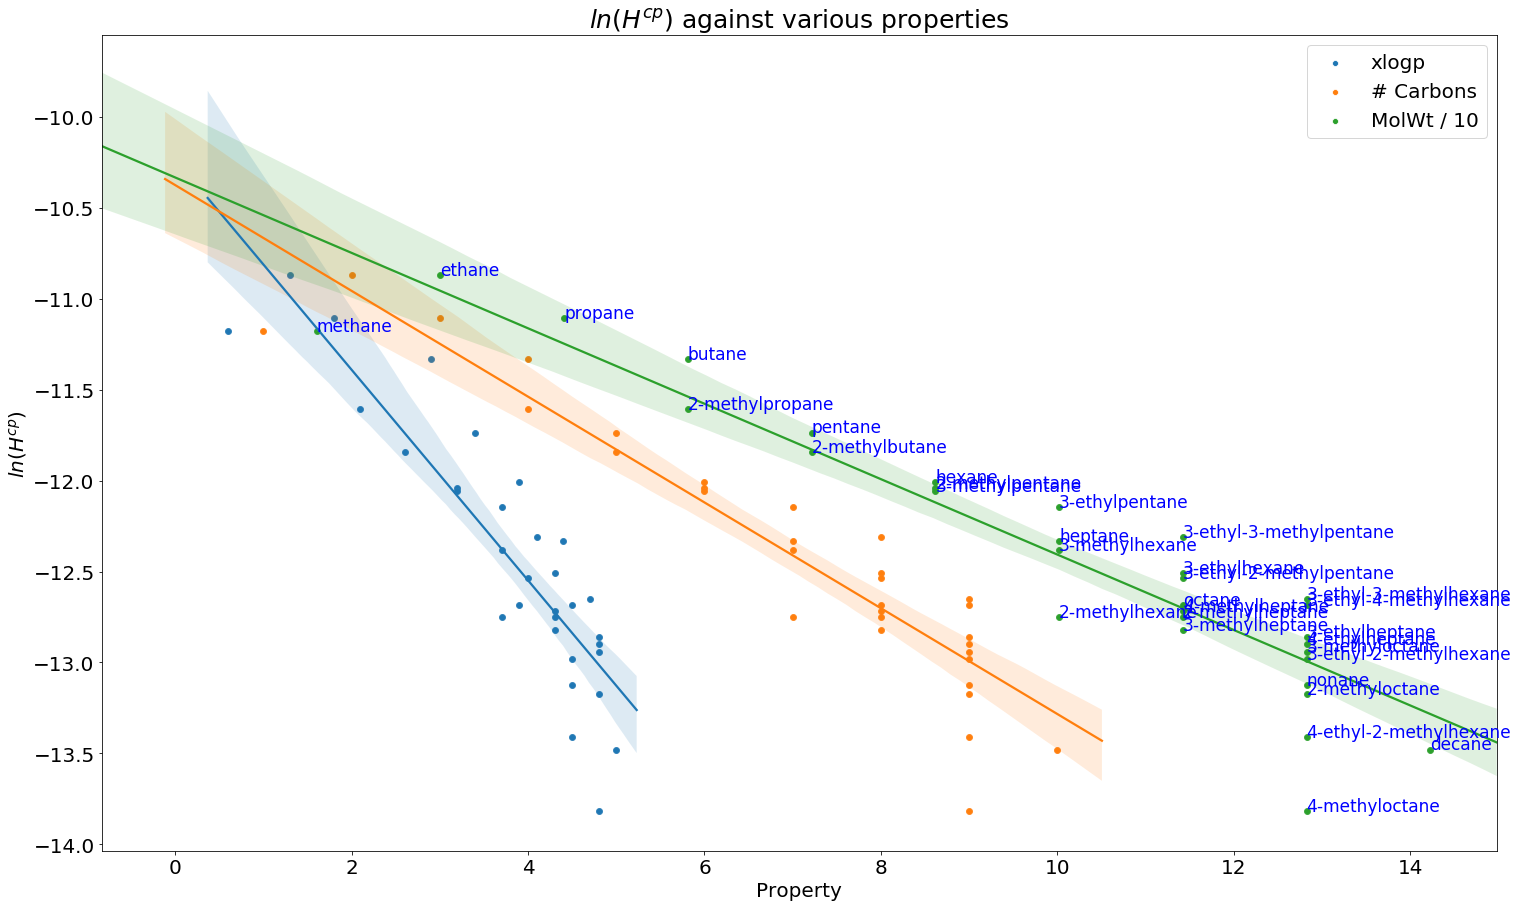

In [4]:
variable_list = ['xlogp', 'Carbons', 'MolWt']
label_style = dict(size=17, color='blue')
ax_style = dict(fontsize=20, color='black')
title_style = dict(size=25, color='black')

fig, ax = plt.subplots(figsize=(25, 15))
y = np.log(np.array(linear_hc_df.Constant))
x1 = np.array(np.array(linear_hc_df.xlogp))
plot = sns.scatterplot(x1, y, label = 'xlogp')
line = sns.regplot(x1, y)


x2 = np.array(np.array(linear_hc_df.Carbons))
plot = sns.scatterplot(x2, y, label = '# Carbons')
line = sns.regplot(x2, y)


x3 = np.array(np.array(linear_hc_df.MolWt/10))
plot = sns.scatterplot(x3, y, label = 'MolWt / 10')
line = sns.regplot(x3, y)
for line in range(0, len(linear_hc_df.index)):
     plot.text(linear_hc_df.MolWt.iloc[line]/10, np.log(np.array(linear_hc_df.Constant.iloc[line])),
               linear_hc_df.Species.iloc[line], **label_style)

# x and y swapped as per Jeremy's advice

ax.legend(prop={'size':20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$ln(H^{cp})$', **ax_style)
ax.set_xlabel('Property', **ax_style)
plt.title('$ln(H^{cp})$ against various properties', **title_style)
plt.show()

## Versatile plot
This chunk will work for some pre-defined chunks of the dataframe, plotting the above graph for *one* variable against $ln(H^{cp})$, then performing linear regression to pull out slope and intercept

In [5]:
carbons.index[1]

'ethane'

In [6]:
var_list = list(carbons) #update when more descriptors are added
filter_by = ['Chlorines', 'Carbons'] # for colouring by catagorical variables
number_of = list(range(0, 13)) ; number_of.append('all')
label_style = dict(size=17, color='blue')
ax_style = dict(fontsize=20, color='black')
title_style = dict(size=25, color='black')

@widgets.interact(DataFrame = ['Linear hydrocarbons', 'Noble gases', 
                               'Carboxylic acids', 'Carboxylic acids (minus outliers)',
                              'Benzene Derivatives', 'Linear Chloroalkanes', 'All'],
                  Variable = var_list, AtomFilter = filter_by, Filter = False,
                  NumberOf = number_of, Labels = True)

def plot_henry_graph(DataFrame = 'Linear Chloroalkanes', Variable = 'MolWt',
                     AtomFilter = 'Chlorines', NumberOf = 1, Filter = False,
                     Labels = True):
    if DataFrame == 'Linear hydrocarbons':
        if Filter == False:
            df = linear_hc_df
        if Filter == True:
            df = linear_hc_df.loc[linear_hc_df[AtomFilter] == NumberOf]
    if DataFrame == 'Noble gases':
        if Filter == False:
            df = noble_gases
        if Filter == True:
            df = noble_gases.loc[noble_gases[AtomFilter] == NumberOf]
    if DataFrame == 'Carboxylic acids':
        if Filter == False:
            df = carbox_acids
        if Filter == True:
            df = carbox_acids.loc[carbox_acids[AtomFilter] == NumberOf]
    if DataFrame == 'Carboxylic acids (minus outliers)':
        if Filter == False:
            df = carbox_minus_outliers
        if Filter == True:
            df = carbox_minus_outliers.loc[carbox_minus_outliers[AtomFilter] == NumberOf]
    if DataFrame == 'Benzene Derivatives':
        if Filter == False:
            df = benzene_derivatives
        if Filter == True:
            df = benzene_derivatives.loc[benzene_derivatives[AtomFilter] == NumberOf]
    if DataFrame == 'Linear Chloroalkanes':
        if Filter == False:
            df = linear_chloro_alkanes
        if Filter == True:
            df = linear_chloro_alkanes.loc[linear_chloro_alkanes[AtomFilter] == NumberOf]
    if DataFrame == 'All':
        if Filter == False:
            df = data
        if Filter == True:
            df = data.loc[data[AtomFilter] == NumberOf]
        
    label_style = dict(size=17, color='blue')
    ax_style = dict(fontsize=20, color='black')
    title_style = dict(size=25, color='black')
    
    fig, ax = plt.subplots(figsize=(20, 10))
    y = np.log(np.array(df.Constant))
    x = np.array(np.array(df[Variable]))
    
    try:
        line = sns.regplot(x, y, data=df, marker='x')
    except Exception as e:
        print(e, 'This data isn\'t available yet / can\'t be plotted')
    try:
        plot = sns.scatterplot(x, y, data=df, s=100)
    except Exception as e:
        print(e, 'This data isn\'t available yet / can\'t be plotted')
    if Labels == True:
        for line in range(0, len(df.index)):
            plot.text(df[Variable].iloc[line], np.log(np.array(df.Constant.iloc[line])),
                      df.Species.iloc[line], **label_style)
    else:
        pass
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('$ln(H^{cp})$', **ax_style)
    ax.set_xlabel('Property', **ax_style)
    plt.title('$ln(H^{cp})$ against %s for %s' % (Variable, DataFrame), **title_style)

interactive(children=(Dropdown(description='DataFrame', index=5, options=('Linear hydrocarbons', 'Noble gases'…

In [7]:
df_list

['carbons', 'hydrocarbons_df', 'linear_hc_df', 'noble_gases']

interactive(children=(Dropdown(description='DataFrame', options=('carbons', 'hydrocarbons_df', 'linear_hc_df',…

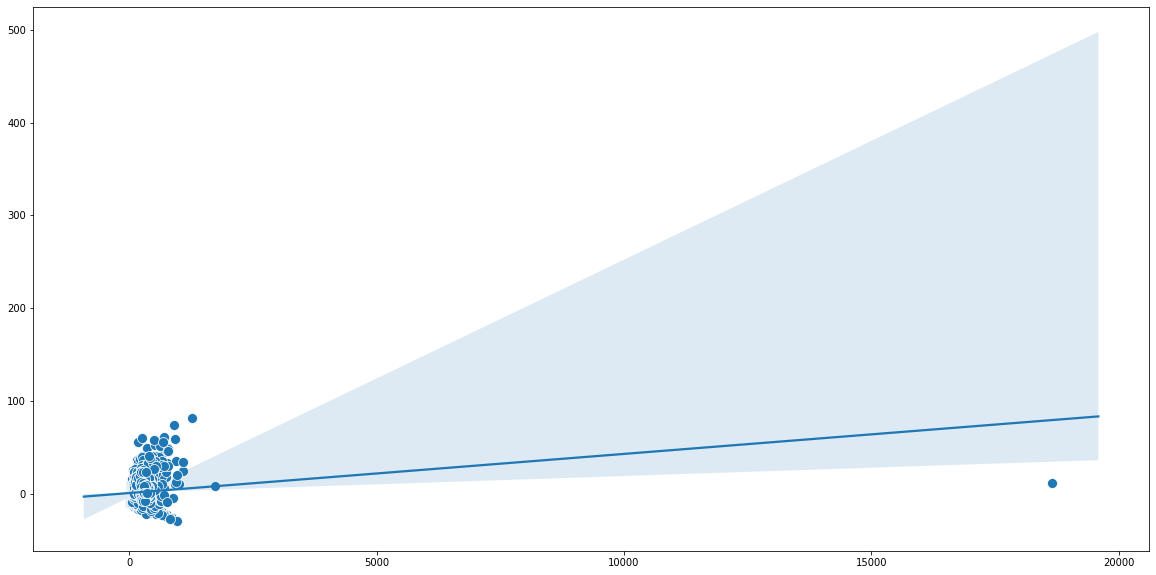

In [8]:
var_list = list(carbons) #update when more descriptors are added
filter_by = ['O', 'N', 'P', 'S', 'F', 'Cl', 'Br', 'I', 'C'] # for colouring by catagorical variables
number_of = list(range(0, 13))
label_style = dict(size=17, color='blue')
ax_style = dict(fontsize=20, color='black')
title_style = dict(size=25, color='black')

@widgets.interact(DataFrame = df_list,
                  Variable = var_list, AtomFilter = filter_by, Filter = False,
                  NumberOf = number_of, Labels = True)

def plot_henry_graph(DataFrame = 'carbons', Variable = 'MolWt',
                     AtomFilter = 'Chlorines', NumberOf = 1, Filter = False,
                     Labels = True):
    df = eval(DataFrame)
    
    if Filter == True:
        df = df.loc[df[AtomFilter] == NumberOf]
    label_style = dict(size=17, color='blue')
    ax_style = dict(fontsize=20, color='black')
    title_style = dict(size=25, color='black')
    
    fig, ax = plt.subplots(figsize=(20, 10))
    y = np.log(np.array(df.Constant))
    x = np.array(np.array(df[Variable]))
    
    try:
        line = sns.regplot(x, y, data=df, marker='x')
    except Exception as e:
        print(e, 'This data isn\'t available yet / can\'t be plotted')
    try:
        plot = sns.scatterplot(x, y, data=df, s=100)
    except Exception as e:
        print(e, 'This data isn\'t available yet / can\'t be plotted')
    if Labels == True:
        for line in range(0, len(df.index)):
            plot.text(df[Variable].iloc[line], np.log(np.array(df.Constant.iloc[line])),
                      df.Species.iloc[line], **label_style)
    else:
        pass
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('$ln(H^{cp})$', **ax_style)
    ax.set_xlabel('Property', **ax_style)
    plt.title('$ln(H^{cp})$ against %s for %s' % (Variable, DataFrame), **title_style)

# Observations
Higher $H^{cp}$ = higher solubility

This shows a few trends:
- Increased lienar hydrocarbon molecular weight decreases $H^{cp}$
- Increased noble gas atomic weight increases $H^{cp}$
- Increased carboxylic acid molecular weight decreases $H^{cp}$
- Decreased affinity for water (higher $log(P)$) decreases solubility (both hydrocarbons and carboxylic acids)

# Moving forward
These trends are to be expected. We now need to look at other possible factors affecting solubility. I'll look into :
- Branched hydrocarbons
- Functional groups
- Volume of molecules


- Look into electronic structure? - polarity/dipole moments

- try logp$^2$

- multilinear regression

- look into log(p)$^2$? benz ders look a bit quadratic

- swap axes for plots

- try rdkit descriptors first.

- why are the odd ones odd - do any descriptors 

- SMILES STRING into rdkit to get volume?


- For the set of linear chloroalkanes, seperate by number of chlorines attached
- For the benzene derivatives, split by functional group type / number of

To improve the notebook and make my life easier later on:
- Define a function which plots the graph above for any given slice of the dataframe
- Introduce a direct link to the supplement so the set of constants can be updated when the dataset changes

# Questions and Ideas

Each species has several constants - for now I've used the first constant in each case. How should I approach this?
> This is fine - the paper's author gave the Henry's Law constant he thought was best as the first in each case. Fine to use the first in each set

As Henry's Law deals specifically with gases (?) - is it reasonable to provide Henry's law constants for species that are not gases at standard temperature?
> vapor presssures - see how they did the measurements (look at miscibility) (could raise errors at low temperatures)

Are there any other laws dealing with concentration of gases in liquids? Can/should we relate these to Henry's law?
> 

Are there any other predictors Jeremy has in mind?
> look at the descriptors available in rdkit

Could the 'stability' of a species in gaseous state play a role in it's solubility? Perhaps a species which ~repels other molecules of its kind~ would find more stability in gaseous form? 
XlogP site says: *Also it is a good measure of the solubility in water and organic compounds, although also other factors (e.g. the stability of the crystalline material) play a role.*
> 

Henry's Law doesn't account for chemical equilibria in the aqueous phase - is there a way to account for this for all molecules or would this have to be done case by case? Would this already be accounted for in the given constants?
> dont worry about these right now - they should lie out of where expected
> for acid base reaction - look at pkas? see if theres a region where relationship falls apart

This relationship is temperature dependant - is there a way to factor this into predictions? Would I need Henry's Law constants for the species at varying temperatures?
> dont worry about at this stage

Some species have datapoints that are clearly outliers (see octadecanoic acid) - is there a reason these constants vary so wildly in some cases?
>

\[N+\]([O-])=O 

In [9]:
contains_carbon.loc[:, ['Species', 'SMILES']]

NameError: name 'contains_carbon' is not defined

0-15, 530, 531, 

In [ ]:
contains_carbon.loc[contains_carbon.Species == 'propene']

In [ ]:
henry_df['Species'] = name_list

In [ ]:
name_list = []
for name in henry_df.Species:
    if name[0] == ' ':
        string = name
        minus_space = string.split(sep = ' ')[1:]
        name = str('')
        for chunk in minus_space:
            name += chunk
    name_list.append(name)
name_list

In [ ]:
print(name[1])

In [ ]:
henry_df.iloc[351:]

# Same plot for linear hydrocarbons but using Kh rather than H

In [15]:
linear_hc_df = pd.read_csv('filtered_organics_desc_kh.csv')
linear_hc_df.rename({'Unnamed: 0':'SMILES', '0':'Species'}, axis=1, inplace=True)
linear_hc_df.set_index('SMILES', inplace=True)
linear_smiles_list = []
for i in range(1, 40):
    smiles_linear = i * 'C'
    linear_smiles_list.append(smiles_linear)
    

linear_hc_df = linear_hc_df.loc[linear_smiles_list]
linear_hc_df.head()

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


Species    Kh_mean   Kh_first  Varying_1  Varying_2  Varying_3  \
SMILES                                                                   
C       methane  11.123407  11.176453        1.0        1.0        0.0   
CC       ethane  10.798677  10.871072        1.0        1.0        0.0   
CCC     propane  11.161176  11.107460        0.0        0.0        0.0   
CCCC     butane  11.334422  11.330604        1.0        0.0        0.0   
CCCCC   pentane  11.716003  11.736069        0.0        0.0        0.0   

        Varying_4  Varying_5  Varying_6  Varying_7  Varying_8  Varying_9  \
SMILES                                                                     
C             0.0        0.0        0.0        0.0        0.0        0.0   
CC            0.0        0.0        0.0        0.0        0.0        0.0   
CCC           0.0        0.0        0.0        0.0        0.0        0.0   
CCCC          0.0        0.0        0.0        0.0        0.0        0.0   
CCCCC         0.0        0.0        0.0        0.0        0.0        0.0   

           MW    AMW     Sv      Se     Sp      Si     Mv     Me     Mp  \
SMILES                                                                    
C       16.05  3.210  2.054   4.767  2.523   5.830  0.411  0.953  0.505   
CC      30.08  3.760  3.580   7.651  4.284   9.246  0.448  0.956  0.536   
CCC     44.11  4.010  5.107  10.534  6.046  12.661  0.464  0.958  0.550   
CCCC    58.14  4.153  6.634  13.418  7.807  16.076  0.474  0.958  0.558   
CCCCC   72.17  4.245  8.161  16.302  9.568  19.491  0.480  0.959  0.563   

           Mi   nAT  nSK   nBT  nBO  nBM  SCBO  RBN    RBF  nDB  nTB  nAB  \
SMILES                                                                      
C       1.166   5.0  1.0   4.0  0.0  0.0   0.0  0.0  0.000  0.0  0.0  0.0   
CC      1.156   8.0  2.0   7.0  1.0  0.0   1.0  0.0  0.000  0.0  0.0  0.0   
CCC     1.151  11.0  3.0  10.0  2.0  0.0   2.0  0.0  0.000  0.0  0.0  0.0   
CCCC    1.148  14.0  4.0  13.0  3.0  0.0   3.0  1.0  0.077  0.0  0.0  0.0   
CCCCC   1.147  17.0  5.0  16.0  4.0  0.0   4.0  2.0  0.125  0.0  0.0  0.0   

          nH   nC   nN   nO   nS   nF  nCL  nBR   nI  nHM  nHet   nX    H%  \
SMILES                                                                       
C        4.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  80.0   
CC       6.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  75.0   
CCC      8.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  72.7   
CCCC    10.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  71.4   
CCCCC   12.0  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  70.6   

          C%   N%   O%   X%  nCsp3  nCsp2  nCsp  nCIC  nCIR  TRS  Rperim  \
SMILES                                                                     
C       20.0  0.0  0.0  0.0    1.0    0.0   0.0   0.0   0.0  0.0     0.0   
CC      25.0  0.0  0.0  0.0    2.0    0.0   0.0   0.0   0.0  0.0     0.0   
CCC     27.3  0.0  0.0  0.0    3.0    0.0   0.0   0.0   0.0  0.0     0.0   
CCCC    28.6  0.0  0.0  0.0    4.0    0.0   0.0   0.0   0.0  0.0     0.0   
CCCCC   29.4  0.0  0.0  0.0    5.0    0.0   0.0   0.0   0.0  0.0     0.0   

        Rbrid  MCD  RFD  RCI  NRS  NNRS  nR03  nR04  nR05  nR06  nR07  nR08  \
SMILES                                                                        
C         0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CC        0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CCC       0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CCCC      0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
CCCCC     0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

        nR09  nR10  nR11  nR12  nBnz  ARR  D/Dtr03  D/Dtr04  D/Dtr05  D/Dtr06  \
SMILES                                                                          
C        0.0   0.0   0.0   0.0   0.0  0.0      0.0      0.0      0.0      0.0   
CC       0.0 

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


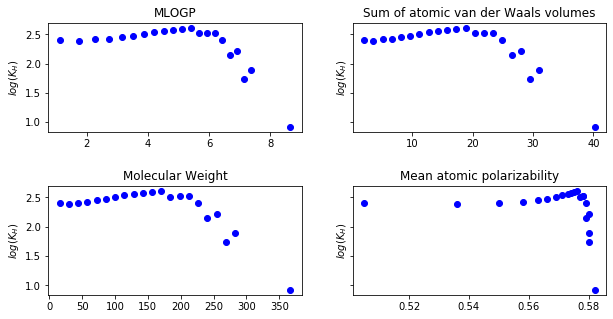

In [56]:
label_style = dict(size=17, color='blue')
ax_style = dict(fontsize=20, color='black')
title_style = dict(size=25, color='black')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

y = np.log(np.array(linear_hc_df.Kh_mean))

x1 = np.array(np.array(linear_hc_df.MLOGP))
ax1.plot(x1, y, 'bo')
ax1.set_ylabel('$log(K_H)$')
ax1.set_title('MLOGP')
#ax1 = plt.scatter(x1, y, label = 'mlogp')
#line = sns.regplot(x1, y)


x2 = np.array(np.array(linear_hc_df.Sv))
ax2.plot(x2, y, 'bo')
ax2.set_ylabel('$log(K_H)$')
ax2.set_title('Sum of atomic van der Waals volumes')
#ax2 = plt.scatter(x2, y, label = '# Carbons')
#line = sns.regplot(x2, y)


x3 = np.array(np.array(linear_hc_df.MW))
ax3.plot(x3, y, 'bo')
ax3.set_ylabel('$log(K_H)$')
ax3.set_title('Molecular Weight')
#ax3 = plt.scatter(x3, y, label = 'MolWt / 10')
#line = sns.regplot(x3, y)

x4 = np.array(np.array(linear_hc_df['Mp']))
ax4.plot(x4, y, 'bo')
ax4.set_ylabel('$log(K_H)$')
ax4.set_title('Mean atomic polarizability')
#ax4 = plt.scatter(x4, y, label = 'MolWt / 10')
#line = sns.regplot(x4, y)


# x and y swapped as per Jeremy's advice

#ax.legend(prop={'size':20})
#ax.tick_params(axis='both', which='major', labelsize=20)
#ax.set_ylabel('$ln(K_{H})$', **ax_style)
#ax.set_xlabel('Property', **ax_style)
#plt.title('$ln(K_{H})$ against various properties', **title_style)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

to_image = plt.gcf()
to_image.savefig('linear_plots_linear_hydrocarbons.png')
plt.show()
